In [1]:
from pymoo.optimize import minimize
from jobshop.params import job_params_from_json
from jobshop.heuristic.brkga import BRKGA, Decoder, LSDecoder, JobShopProblem, DuplicatesEncoder
from jobshop.heuristic.brkga.termination import TargetTermination

Thesis with target values [link](https://repositorio.ufmg.br/bitstream/1843/33554/1/Tradu%C3%A7%C3%A3o%20Autom%C3%A1tica%20de%20Problemas%20de%20Escalonamento%20Job%20Shop%20Flex%C3%ADvel%20com%20Bloqueio%20para%20Aut%C3%B4matos%20Utilizando%20a%20Teoria%20de%20Controle%20Supervis%C3%B3rio%20-%20PDF_A.pdf)

In [2]:
params = job_params_from_json("./../instances/orlib/mt10.json")

In [3]:
brkga = BRKGA(
    pop_size=100,
    perc_elite=0.2,
    perc_mutants=0.15,
    bias=0.8,
)
problem = JobShopProblem(params, LSDecoder)

In [4]:
res = minimize(problem, brkga, termination=TargetTermination(200, 950), verbose=True, seed=42)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  1.305980E+03 |  1.135000E+03
     2 |      180 |  1.270430E+03 |  1.135000E+03
     3 |      260 |  1.259160E+03 |  1.101000E+03
     4 |      340 |  1.236770E+03 |  1.079000E+03
     5 |      420 |  1.233530E+03 |  1.079000E+03
     6 |      500 |  1.226850E+03 |  1.079000E+03
     7 |      580 |  1.230290E+03 |  1.079000E+03
     8 |      660 |  1.236960E+03 |  1.056000E+03
     9 |      740 |  1.201290E+03 |  1.044000E+03
    10 |      820 |  1.214480E+03 |  1.044000E+03
    11 |      900 |  1.204400E+03 |  1.044000E+03
    12 |      980 |  1.205400E+03 |  1.044000E+03
    13 |     1060 |  1.209860E+03 |  1.044000E+03
    14 |     1140 |  1.207070E+03 |  1.044000E+03
    15 |     1220 |  1.205900E+03 |  1.044000E+03
    16 |     1300 |  1.190670E+03 |  9.880000E+02
    17 |     1380 |  1.192040E+03 |  9.880000E+02
    18 |     1460 |  1.188810E+03 |  9.880000E+02
    19 |     1540 |  1.171370E+03 |  9.880000E+02


In [5]:
graph = problem.decoder.build_graph_from_string(res.X)

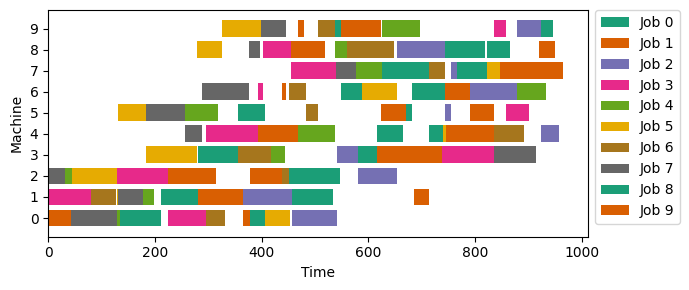

In [6]:
graph.plot()

In [7]:
import numpy as np

In [8]:
A = np.atleast_2d([])
b = []

In [9]:
A

array([], shape=(1, 0), dtype=float64)

In [37]:
ops = [o for o in graph.O]
N = len(ops)

A = np.empty((0, N))
b = []

for m, j in ops:
    PJ = graph.precede_job(m, j)
    if PJ is not None:
        row = np.zeros((1, N))
        row[0, ops.index((m, j))] = -1
        row[0, ops.index(PJ.code)] = 1
        b.append(PJ.duration)
        A = np.vstack((A, row))
    PM = graph.precede_machine(m, j)
    if PM is not None:
        row = np.zeros((1, N))
        row[0, ops.index((m, j))] = -1
        row[0, ops.index(PM.code)] = 1
        b.append(PM.duration)
        A = np.vstack((A, row))

b = - np.array(b)
c = np.ones(N)

In [38]:
from scipy.optimize import linprog

In [39]:
%%time

for _ in range(1000):

    sol = linprog(c, A_ub=A, b_ub=b, method="highs")

CPU times: total: 2.05 s
Wall time: 2.28 s


In [30]:
from jobshop.heuristic.evaluation import calc_makespan

In [40]:
%%time

for _ in range(1000):

    calc_makespan(graph)

CPU times: total: 1.77 s
Wall time: 2.14 s


In [24]:
sol.x

array([378.,   0., 456., 224., 129., 407., 295.,  43., 135., 365., 456.,
       685., 365.,   0., 177., 129.,  81., 131., 211., 280., 537., 224.,
       580., 129.,  31.,  45., 439.,   0., 452., 378., 580., 616., 541.,
       737., 417., 183., 356., 835., 280., 685., 616., 394., 924., 295.,
       469., 740., 836., 257., 714., 746., 671., 790., 744., 857., 257.,
       131., 484., 183., 356., 624., 682., 744., 790., 394., 879., 588.,
       452., 289., 548., 439., 766., 847., 754., 455., 576., 822., 714.,
       540., 625., 919., 822., 919., 654., 403., 538., 278., 559., 377.,
       744., 455., 924., 469., 879., 835., 625., 326., 505., 398., 537.,
       548.])

In [27]:
p = np.array([o.duration for o in graph.O.values()])

In [28]:
max(p + sol.x)

964.0